In [14]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [28]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
#pip install lightgbm
from lightgbm import LGBMClassifier


from sklearn.model_selection import ParameterSampler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt


In [29]:
learners = [
    {
        "learner": XGBClassifier,
        "params": {
            "learning_rate": [0.1],
            "colsample_bytree": [0.15, 0.25, 0.5, 0.75, 1],
            "colsample_bylevel": [1],
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
            "gamma": [0, 0.01, 0.05, 0.1, 0.25, 0.5],
            "subsample": [0.5, 0.75, 1],
            "min_child_weight": [1, 5, 10, 15, 25, 50, 100],
            "base_score": [0.52],
            "n_estimators": [50, 100, 200, 300, 500, 1000] 
            }
    },
    {
        "learner": RandomForestClassifier,
        "params": {
            "max_depth": [3, 4, 5, 10, 25, None],
            "max_features": ["auto", 0.1, 0.25, 0.5, 0.75, 1],
            "min_weight_fraction_leaf": [0, 0.01, 0.001],
            "bootstrap": [True, False],
            "n_jobs": [-1],
            "n_estimators": [50, 100, 200, 300, 500, 1000]             
            }
    },
    {
        "learner": ExtraTreesClassifier,
        "params": {
            "max_depth": [None],
            "max_features": ["auto", 0.1],
            "min_weight_fraction_leaf": [0, 0.01, 0.001],
            "bootstrap": [True, False],
            "n_jobs": [-1],
            "n_estimators": [50, 100, 200, 300, 500, 1000]             
            }
    },
    {
        "learner": LogisticRegression,
        "params": {
            "penalty": ["l2"],
            "C": [0.001, 0.01, 0.1, 1, 10, 100, 100],
            }
    },
    {#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        "learner": LGBMClassifier,
        "params": {
            "boosting_type": ["gbdt", "dart", "goss"],
            "max_depth": [-1, 3, 5, 10, 20],
            "min_child_samples": [20, 30, 40, 50],
            "n_estimators": [50, 100, 200, 300],
            "num_leaves": [20, 31, 50, 80],
            }
        
    }
]


In [30]:
Bank_procesada = pd.read_csv("bank marketing/bankMarketingTotal.csv",sep=";") #bank marketing/bankMarketingTotal.csv

In [31]:
#Elimino columnas que no se utilizaran en el entrenamiento del modelo y separo en train y test
X = Bank_procesada.drop(columns = ["default", "y","bucketsAge", "nr.employed"])
Y = Bank_procesada.y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [32]:
results = dict()
paramsUsed = {} #almacenamos los parámetros para reproducir

for x in range(0,10):
    candidate = np.random.choice(learners)
    learnerName = candidate["learner"].__name__
    params = list(ParameterSampler(candidate["params"], 1))[0]
    if learnerName not in paramsUsed:
        paramsUsed[learnerName] = []
    if params in paramsUsed[learnerName]:
        continue
    paramsUsed[learnerName].append(params)
    learner = candidate["learner"](**params)
    learner.fit(X_train, Y_train)
    print("{}_{}".format(learnerName, str(x)))
    results["{}_{}".format(learnerName, str(x))] = {"params": params, 
                                                    "results": learner.predict_proba(X_test)[:,1],
                                                    "target": Y_test.values}

RandomForestClassifier_0
RandomForestClassifier_1
ExtraTreesClassifier_2
ExtraTreesClassifier_3
RandomForestClassifier_4
LGBMClassifier_5
LGBMClassifier_6
XGBClassifier_7
RandomForestClassifier_8
XGBClassifier_9


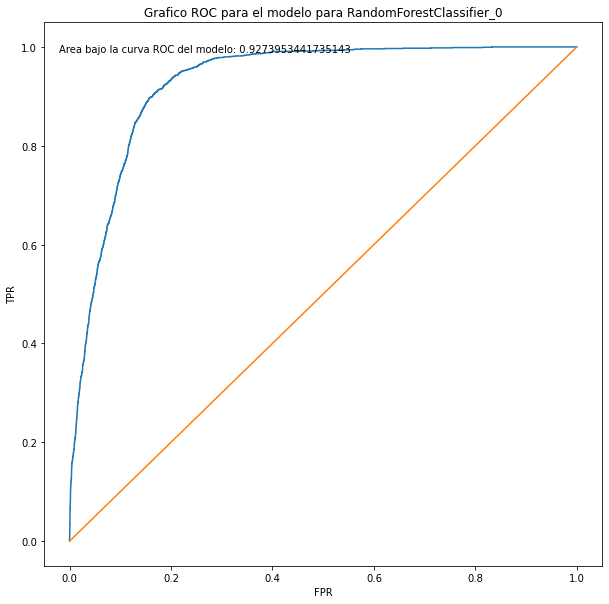

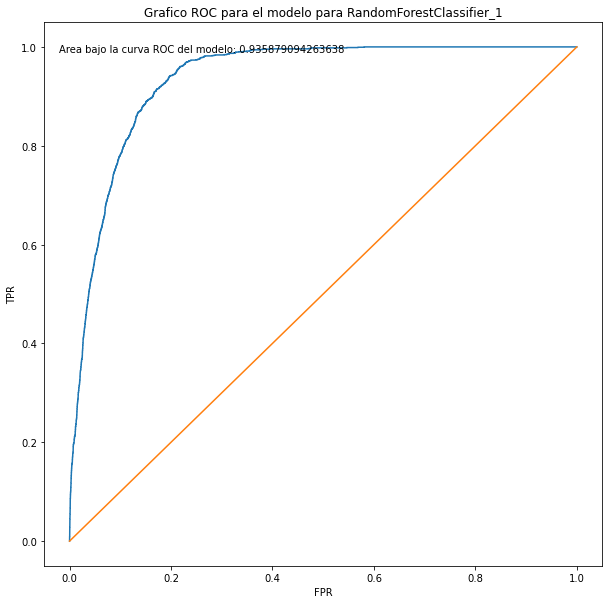

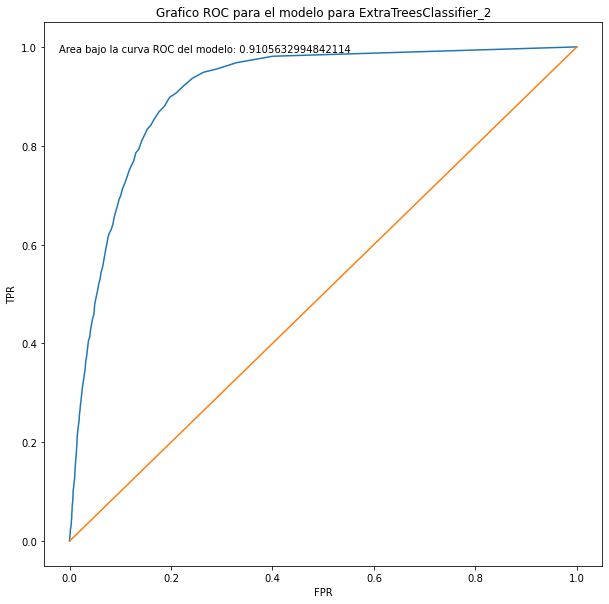

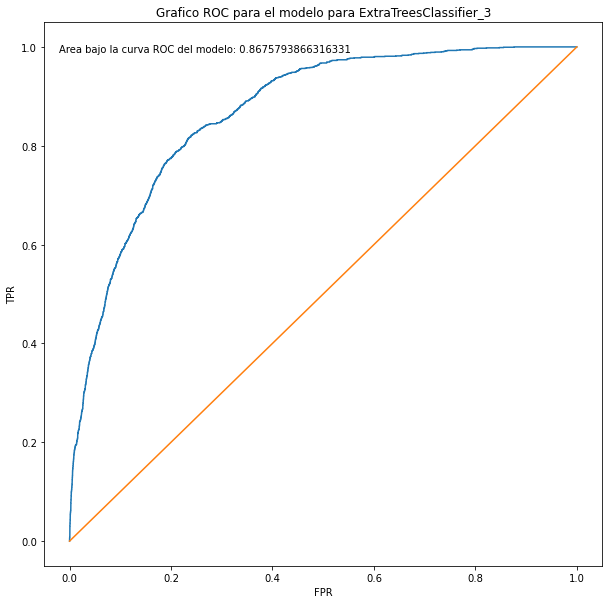

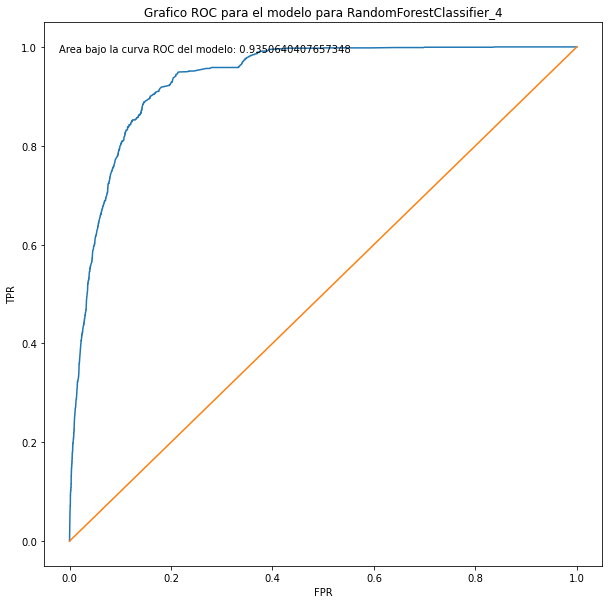

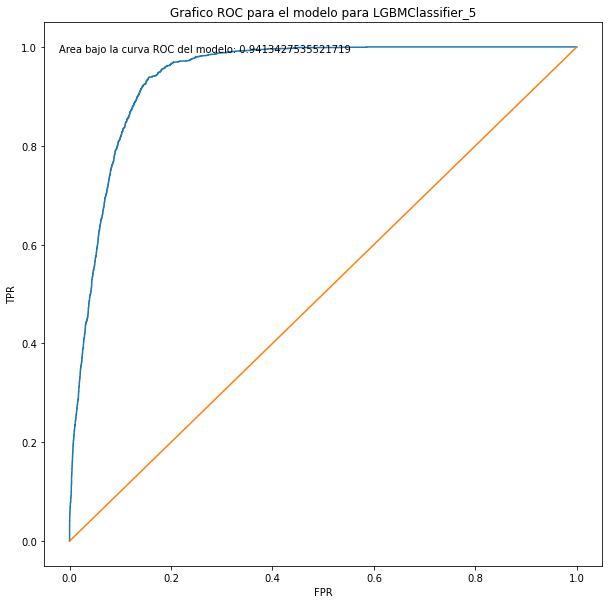

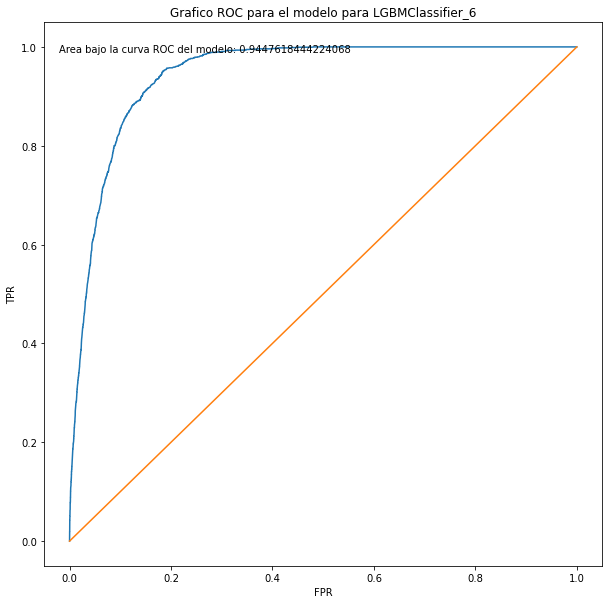

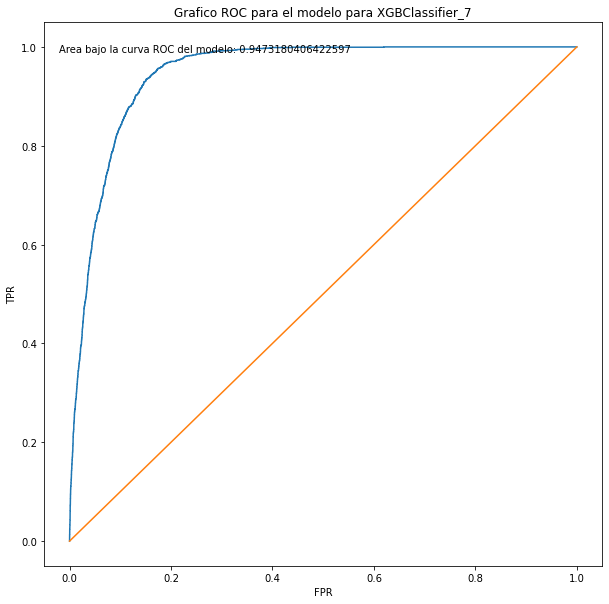

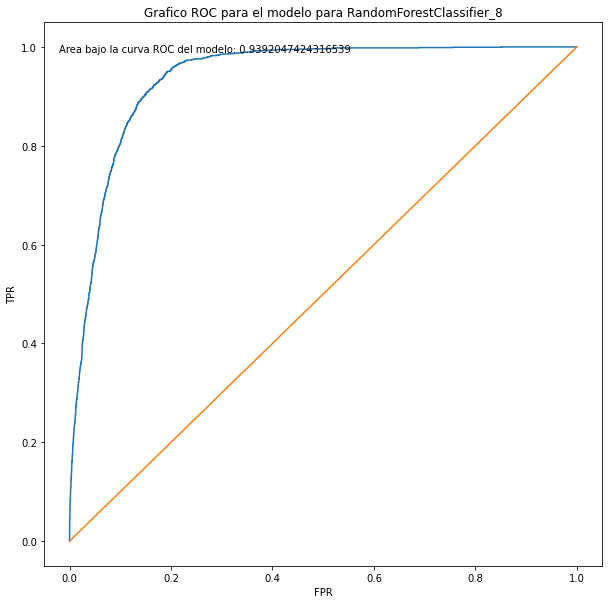

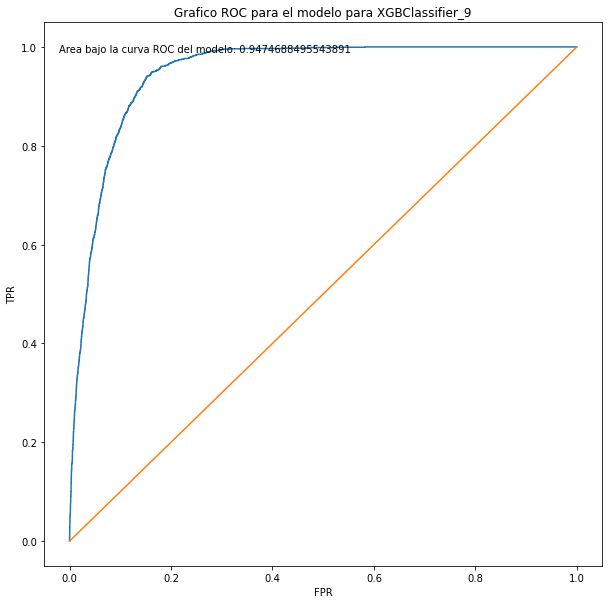

In [33]:
for y in results:
    result = results[y]
    areaBajoCurvaRoc = roc_auc_score(result["target"], result["results"])
    fpr, tpr, _ = roc_curve(result["target"], result["results"])
    plt.figure(figsize=(10,10))
    plt.title("Grafico ROC para el modelo para {}".format(y))
    plt.plot(fpr, tpr)
    plt.plot([0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
    plt.show()

In [34]:
results['XGBClassifier_9']

{'params': {'subsample': 1,
  'n_estimators': 100,
  'min_child_weight': 25,
  'max_depth': 15,
  'learning_rate': 0.1,
  'gamma': 0.01,
  'colsample_bytree': 0.25,
  'colsample_bylevel': 1,
  'base_score': 0.52},
 'results': array([0.05508499, 0.01020102, 0.00907945, ..., 0.0102772 , 0.01453556,
        0.02452775], dtype=float32),
 'target': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [35]:
best = 0
best_model=""
best_result={}
for y in results:
    result = results[y]
    areaBajoCurvaRoc = roc_auc_score(result["target"], result["results"])
    if(areaBajoCurvaRoc>best):
        best_model=y
        best=areaBajoCurvaRoc
        best_result=result
print(best_model)
print(best)
print(best_result)

XGBClassifier_9
0.9474688495543891
{'params': {'subsample': 1, 'n_estimators': 100, 'min_child_weight': 25, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.25, 'colsample_bylevel': 1, 'base_score': 0.52}, 'results': array([0.05508499, 0.01020102, 0.00907945, ..., 0.0102772 , 0.01453556,
       0.02452775], dtype=float32), 'target': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}
